Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

In [1]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os  # importing os module
import zipfile # importing zipfile module

print("Extracting the Skin Cancer Data...")
os.chdir('/content/gdrive/MyDrive')
!unzip CNN_assignment.zip

Extracting the Skin Cancer Data...
Archive:  CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  


### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### One instance of all the nine classes present in the dataset

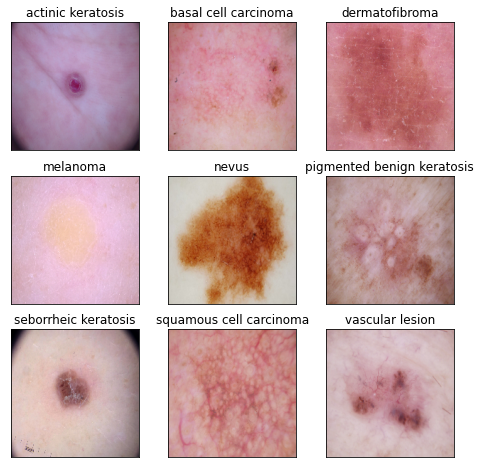

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for num in range(len(class_names)):
        ax = fig.add_subplot(3, 3, 1 + num, xticks=[], yticks=[])
        ax.set_title(class_names[num])
        plt.imshow(images[num].numpy().astype("uint8"))

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.Conv2D(128,3,padding='same',activation= 'relu'),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(len(class_names),activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 128)     73856     
                                                                 
 flatten (Flatten)           (None, 4147200)           0         
                                                                 
 dense (Dense)               (None, 128)               530841728 
                                                                 
 dense_1 (Dense)             (None, 9)                 1

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])
#Callback to save the Keras model or model weights at some frequency.
model_1_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_1.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
#Stop training when a monitored metric has stopped improving.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, mode = "auto")

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 128)     73856     
                                                                 
 flatten (Flatten)           (None, 4147200)           0         
                                                                 
 dense (Dense)               (None, 128)               530841728 
                                                                 
 dense_1 (Dense)             (None, 9)                 1

### Train the model

In [16]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[model_1_checkpoint_callback,callback])

Epoch 1/20
56/56 [==============================] - 29s 527ms/step - loss: 2.0178 - accuracy: 0.2617 - val_loss: 2.2496 - val_accuracy: 0.2609
Epoch 2/20
56/56 [==============================] - 16s 285ms/step - loss: 1.7988 - accuracy: 0.3588 - val_loss: 3.1024 - val_accuracy: 0.1739
Epoch 3/20
56/56 [==============================] - 27s 487ms/step - loss: 1.5130 - accuracy: 0.4732 - val_loss: 2.0590 - val_accuracy: 0.3043
Epoch 4/20
56/56 [==============================] - 16s 286ms/step - loss: 1.3559 - accuracy: 0.5162 - val_loss: 2.5184 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 16s 284ms/step - loss: 1.2631 - accuracy: 0.5564 - val_loss: 3.5432 - val_accuracy: 0.1304
Epoch 6/20
56/56 [==============================] - 16s 285ms/step - loss: 1.1008 - accuracy: 0.6339 - val_loss: 3.3096 - val_accuracy: 0.2174
Epoch 7/20
56/56 [==============================] - 16s 286ms/step - loss: 0.9174 - accuracy: 0.6635 - val_loss: 3.5342 - val_accuracy: 0.2174

### Visualizing training results

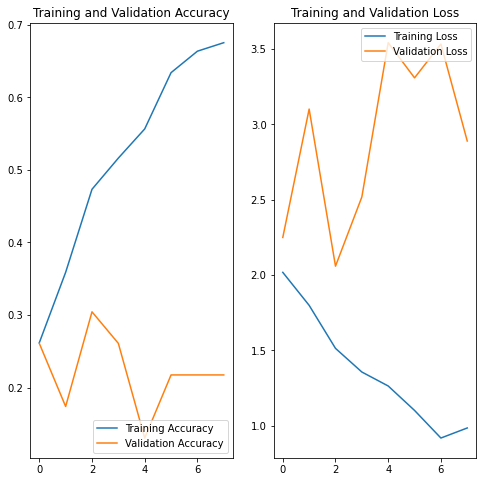

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(8)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
From the above it is clearly seems model started getting Over fit as the training accuracy started increasing and validation accuracy decreasing.

### Todo:
### Create the model, compile and train the model


### Compiling the model

In [28]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = Sequential([
    # Rescaling
    layers.Rescaling(scale = 1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(128,3,padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    # Dropout Layer
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(len(class_names),activation='softmax')])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 45, 45, 128)      

### Training the model

In [29]:
## Your code goes here, note: train your model for 20 epochs
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])
#Callback to save the Keras model or model weights at some frequency.
model_1_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_2.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
#Stop training when a monitored metric has stopped improving.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, mode = "auto")

In [30]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[model_1_checkpoint_callback,callback])

Epoch 1/20
56/56 [==============================] - 4s 44ms/step - loss: 2.0232 - accuracy: 0.2746 - val_loss: 2.3241 - val_accuracy: 0.2174
Epoch 2/20
56/56 [==============================] - 2s 38ms/step - loss: 1.7570 - accuracy: 0.3677 - val_loss: 2.2112 - val_accuracy: 0.1739
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.6549 - accuracy: 0.4202 - val_loss: 2.3044 - val_accuracy: 0.2609
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5509 - accuracy: 0.4470 - val_loss: 2.2225 - val_accuracy: 0.3478
Epoch 5/20
56/56 [==============================] - 2s 38ms/step - loss: 1.4246 - accuracy: 0.5106 - val_loss: 2.1656 - val_accuracy: 0.3478
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3613 - accuracy: 0.5329 - val_loss: 2.5038 - val_accuracy: 0.3043
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.2931 - accuracy: 0.5413 - val_loss: 3.3753 - val_accuracy: 0.3043
Epoch 8/20
56

### Visualizing the results

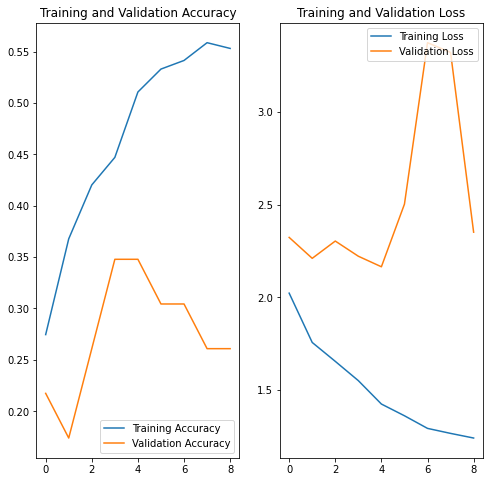

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(9)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

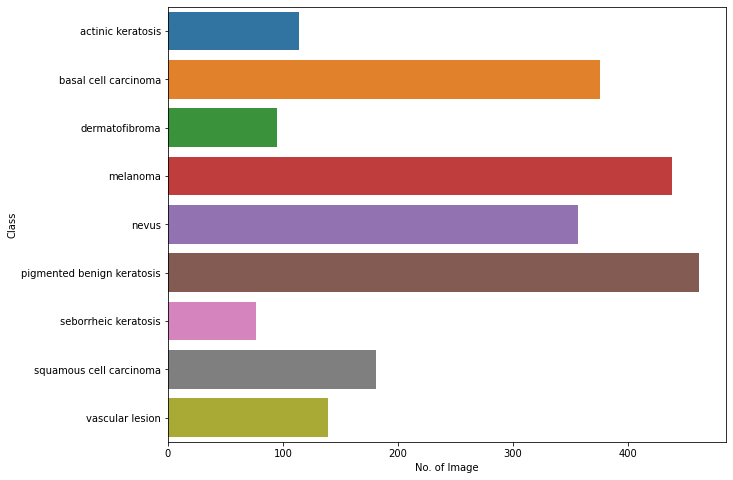

In [34]:
## Your code goes here.
#count number of image in each classes
count= []
for path in pathlib.Path(data_dir_train).iterdir():
    if path.is_dir():
        count.append(len([name for name in os.listdir(path)
                            if os.path.isfile(os.path.join(path, name))]))
#name of the classes
sub_directory = [name for name in os.listdir(data_dir_train)
                if os.path.isdir(os.path.join(data_dir_train, name))]

#dataframe with image count and class.
df_class_ditribution = pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df_class_ditribution,label="Class")

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
Ans: Seborrheic Keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
Ans: pigmented benign keratosis

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [35]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [41]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
print (path_to_training_dataset)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA7BE6F9A10>: 100%|██████████| 500/500 [00:20<00:00, 23.97 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAA3D93EC50>: 100%|██████████| 500/500 [00:20<00:00, 24.40 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAACE4F2D90>: 100%|██████████| 500/500 [00:20<00:00, 23.96 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FAA3D961710>: 100%|██████████| 500/500 [01:34<00:00,  5.28 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FAA3D9551D0>: 100%|██████████| 500/500 [01:36<00:00,  5.17 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAA3D964F90>: 100%|██████████| 500/500 [00:19<00:00, 25.18 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FAA3A125ED0>: 100%|██████████| 500/500 [00:47<00:00, 10.55 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA7BFE32C50>: 100%|██████████| 500/500 [00:21<00:00, 23.28 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAA3D931E10>: 100%|██████████| 500/500 [00:20<00:00, 24.35 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [42]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [44]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030408.jpg_c15d399d-f346-44df-9012-07c7c5b27e53.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_447cac6d-bdd3-4a9c-80b8-496998c3e263.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031040.jpg_6c8ea296-36b0-446f-8244-f8a4cd54ae6b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026857.jpg_1d4fcf7a-635a-467a-af23-ec848d01e4ed.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_5079f26f-49ac-45c3-9edf-f456f4f51b9b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ou

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [51]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [52]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  label_mode='categorical',
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [53]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  label_mode='categorical',
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [54]:
from tensorflow.keras.layers import BatchNormalization
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = Sequential([
    # Rescaling
    layers.Rescaling(scale = 1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(128,3,padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    # Dropout Layer
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(len(class_names),activation='softmax')])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 90, 90, 64)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [55]:
## your code goes here
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])
#Callback to save the Keras model or model weights at some frequency.
model_1_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_3.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
#Stop training when a monitored metric has stopped improving.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, mode = "auto")

#### **Todo:**  Train your model

In [56]:
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[model_1_checkpoint_callback,callback])

Epoch 1/30
169/169 [==============================] - 35s 197ms/step - loss: 2.8248 - accuracy: 0.2047 - val_loss: 2.1952 - val_accuracy: 0.1403
Epoch 2/30
169/169 [==============================] - 34s 197ms/step - loss: 1.9818 - accuracy: 0.2311 - val_loss: 2.1963 - val_accuracy: 0.1403
Epoch 3/30
169/169 [==============================] - 33s 191ms/step - loss: 1.9269 - accuracy: 0.2409 - val_loss: 2.1726 - val_accuracy: 0.1574
Epoch 4/30
169/169 [==============================] - 33s 192ms/step - loss: 1.8441 - accuracy: 0.2832 - val_loss: 2.0519 - val_accuracy: 0.2457
Epoch 5/30
169/169 [==============================] - 34s 193ms/step - loss: 1.8144 - accuracy: 0.2958 - val_loss: 2.0614 - val_accuracy: 0.2673
Epoch 6/30
169/169 [==============================] - 34s 194ms/step - loss: 1.7671 - accuracy: 0.3034 - val_loss: 2.0283 - val_accuracy: 0.2918
Epoch 7/30
169/169 [==============================] - 34s 194ms/step - loss: 1.6967 - accuracy: 0.3225 - val_loss: 1.8946 - val_ac

#### **Todo:**  Visualize the model results

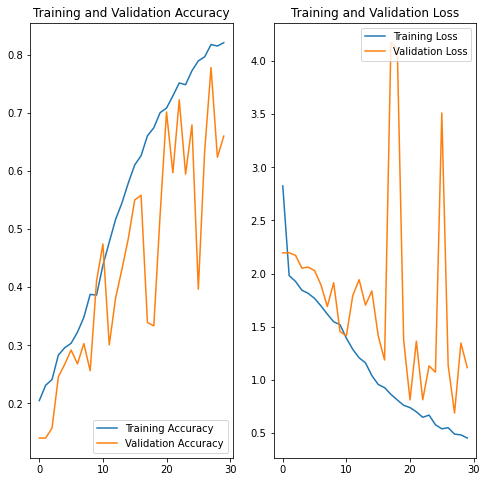

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
The model still seeems to be overfit. However, their is significant improvement in the validation accuracy and loss after performing the class rebalance.
